In [1]:
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr

from metpy.calc import cape_cin, lcl, dewpoint_from_relative_humidity, parcel_profile, pressure_to_height_std
from metpy.units import units

## sondewnpn

### CAPE/CIN calculations

In [2]:
data_path = "/data2/camilacl/git/amazon-storms-aerosols/data/meteo/"

vars = ["pres", "alt", "tdry", "dp", "rh", "wspd"]
sonde = xr.open_dataset(data_path + "sondewnpn/maosondewnpnM1.b1.20140101.054700.cdf").get(vars)

pres = sonde.pres.values * units.hPa
temp = sonde.tdry.values * units.degC
tempd = sonde.dp.values * units.degC

prof = parcel_profile(pres, temp[0], tempd[0]).to("degC")

cape, cin = cape_cin(pres, temp, tempd, prof)

lcl_p, lcl_t = lcl(pres[0], temp[0], tempd[0])
lcl_h = pressure_to_height_std(lcl_p)
zerodeg_p = sonde.swap_dims({'time': 'tdry'}).sortby('tdry').drop_duplicates('tdry').sel(tdry=0., method='nearest').pres.values * units.hPa
zerodeg_h = pressure_to_height_std(zerodeg_p)
wcd = zerodeg_h - lcl_h

In [3]:
xr.open_dataset(data_path + "sondewnpn/maosondewnpnM1.b1.20140101.054700.cdf")

<xarray.Dataset>
Dimensions:      (time: 1945)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-01T05:47:00 ... 2014-01-01T06:...
Data variables: (12/25)
    base_time    datetime64[ns] ...
    time_offset  (time) datetime64[ns] ...
    qc_time      (time) int32 ...
    pres         (time) float32 ...
    qc_pres      (time) int32 ...
    tdry         (time) float32 ...
    ...           ...
    wstat        (time) float32 ...
    asc          (time) float32 ...
    qc_asc       (time) int32 ...
    lat          (time) float32 ...
    lon          (time) float32 ...
    alt          (time) float32 ...
Attributes: (12/42)
    command_line:               sonde_ingest -s mao -f M1 -R -d
    process_version:            ingest-sonde-10.11-0.el5
    ingest_software:            ingest-sonde-10.11-0.el5
    dod_version:                sondewnpn-b1-2.0
    site_id:                    mao
    facility_id:                M1: Manacapuru, Amazonia, Brazil
    ...                         ...
    qc_bit_3_description:       Value is greater than the valid_max.
    qc_bit_3_assessment:        Bad
    qc_bit_4_description:       Difference between current and previous value...
    qc_bit_4_assessment:        Indeterminate
    zeb_platform:               maosondewnpnM1.b1
    history:                    created by user dsmgr on machine iron at 2014...

In [4]:
cape

1019.4720087145726 <Unit('joule / kilogram')>

In [5]:
cin

-69.66805380810689 <Unit('joule / kilogram')>

In [6]:
wcd

4.681923161811762 <Unit('kilometer')>

### Other meteo data (Chakraborty et al. 2018)

In [7]:
# BL humidity (%)
bl_rh = sonde.where(pres>=950*units.hPa).mean("time").rh.values.item()
# Low vertical wind shear (m/s)
low_vws = (sonde.where((pres<=987*units.hPa) & (pres>=887*units.hPa)).mean("time") - sonde.where((pres<=787*units.hPa) & (pres>=687*units.hPa)).mean("time")).wspd.values.item()

### Creating new df with results from all sondes

In [8]:
def fill_meteo_df(sonde):
    # Timestamp
    date = sonde.time[0].values
    
    # CAPE, CIN
    pres = sonde.pres.values * units.hPa
    temp = sonde.tdry.values * units.degC
    tempd = sonde.dp.values * units.degC
    prof = parcel_profile(pres, temp[0], tempd[0]).to("degC")
    cape, cin = cape_cin(pres, temp, tempd, prof)
    
    # WCD
    lcl_p, lcl_t = lcl(pres[0], temp[0], tempd[0])
    lcl_h = pressure_to_height_std(lcl_p)
    zerodeg_p = sonde.swap_dims({'time': 'tdry'}).sortby('tdry').drop_duplicates('tdry').sel(tdry=0., method='nearest').pres.values * units.hPa
    zerodeg_h = pressure_to_height_std(zerodeg_p)
    if zerodeg_h > lcl_h:
        # wcd = zerodeg_h - lcl_h
        wcd = lcl_h
    else:
        # wcd = 0. * units.km
        wcd = lcl_h

    # BL rh, low VWS
    bl_rh = sonde.where(pres>=950*units.hPa).mean("time").rh.values.item()
    low_vws = (sonde.where((pres<=987*units.hPa) & (pres>=887*units.hPa)).mean("time") - sonde.where((pres<=787*units.hPa) & (pres>=687*units.hPa)).mean("time")).wspd.values.item()

    # Filling df
    return {"date": date, "cape_j_kg": cape.magnitude, "cin_j_kg": cin.magnitude, "blrh_pc": bl_rh, "lvws_m_s": low_vws, "wcd": wcd.magnitude}

data_files = glob("/data2/camilacl/git/amazon-storms-aerosols/data/meteo/sondewnpn/maosondewnpnM1.b1.*.cdf")
vars = ["pres", "alt", "tdry", "dp", "rh", "wspd"]
meteo_df = []

for file in data_files:
    sonde = xr.open_dataset(file).get(vars)
    meteo_df.append(fill_meteo_df(sonde))

/tmp/ipykernel_2364399/884857224.py:9: UserWarning: Duplicate pressure(s) [29.959999084472656] hPa provided. Output profile includes duplicate temperatures as a result.
  prof = parcel_profile(pres, temp[0], tempd[0]).to("degC")
/tmp/ipykernel_2364399/884857224.py:9: UserWarning: Duplicate pressure(s) [13.380000114440918 13.460000038146973 13.569999694824219 13.579999923706055 15.289999961853027] hPa provided. Output profile includes duplicate temperatures as a result.
  prof = parcel_profile(pres, temp[0], tempd[0]).to("degC")
/tmp/ipykernel_2364399/884857224.py:9: UserWarning: Duplicate pressure(s) [17.510000228881836] hPa provided. Output profile includes duplicate temperatures as a result.
  prof = parcel_profile(pres, temp[0], tempd[0]).to("degC")
/tmp/ipykernel_2364399/884857224.py:9: UserWarning: Duplicate pressure(s) [15.949999809265137] hPa provided. Output profile includes duplicate temperatures as a result.
  prof = parcel_profile(pres, temp[0], tempd[0]).to("degC")
/tmp/ipy

In [9]:
pd.DataFrame(meteo_df)

,date,cape_j_kg,cin_j_kg,blrh_pc,lvws_m_s,wcd
0,2015-03-28 23:28:00,1012.732984,-81.378200,85.219002,-0.826565,0.091794
1,2014-05-22 05:29:00,2113.826418,0.000000,90.927185,-3.289488,0.149624
2,2014-01-18 05:30:00,902.270160,-92.949643,83.820007,-6.804799,0.073891
3,2015-10-16 17:29:00,2420.200890,0.000000,44.588722,-7.869227,2.011429
4,2014-06-17 17:29:00,0.015857,0.000000,78.088753,-6.282728,0.713063
...,...,...,...,...,...,...
2900,2014-11-08 05:28:00,2822.100705,-27.267009,85.898712,-4.300822,0.141565
2901,2015-02-07 11:47:00,3605.611609,0.000000,72.298958,2.953838,0.245883
2902,2014-06-22 05:27:00,1918.406391,-26.386059,82.931458,-2.139935,0.104887
2903,2014-08-13 23:29:00,3847.462857,-50.360177,64.592690,-2.126530,0.325518


<Axes: xlabel='date'>

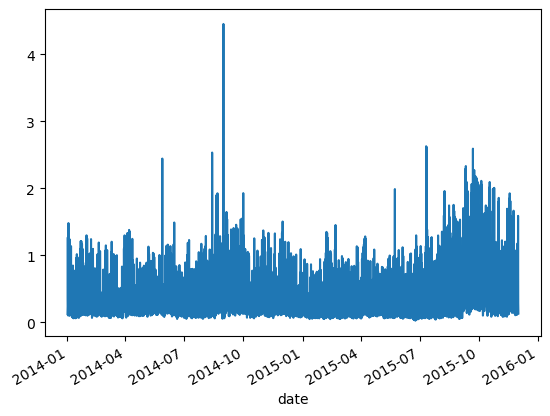

In [10]:
pd.DataFrame(meteo_df).set_index('date').wcd.plot()

In [11]:
pd.DataFrame(meteo_df).sort_values("date").reset_index(drop=True).to_pickle("/home/camilacl/git/amazon-storms-aerosols/data/general/meteo_from_sondewnpn.pickle")

## Surface props (armbe)

In [ ]:
data_path = "/data2/camilacl/git/amazon-storms-aerosols/data/meteo/"

xr.open_dataset(data_path + "armbeatm/maoarmbeatmM1.c1.20140101.003000.custom.nc")

In [ ]:
xr.open_dataset(data_path + "armbeatm/maoarmbeatmM1.c1.20150101.003000.custom.nc").relative_humidity_sfc.dropna("time")

In [ ]:
data_path = "/data2/camilacl/git/amazon-storms-aerosols/data/meteo/"

vars = ["temperature_p", "dewpoint_p", "relative_humidity_p", "wspd"]
armbe = xr.open_dataset(data_path + "armbeatm/maoarmbeatmM1.c1.20140101.003000.custom.nc").get(vars)

pres = armbe.pressure.values * units.hPa
temp = armbe.tdry.values * units.degC
tempd = armbe.dp.values * units.degC

prof = parcel_profile(pres, temp[0], tempd[0]).to("degC")

cape, cin = cape_cin(pres, temp, tempd, prof)

## mwrp

In [ ]:
mwrp = xr.open_dataset(data_path + "mwrp/maomwrpM1.b1.20151029.000919.custom.cdf")
mwrp.where(mwrp['qc_cloudBaseHeight'] == 0, drop=True)
mwrp.cloudBaseHeight.plot()